# Project 3
The prediction of molecular properties is an important task in drug discovery. The molecules' atomic composition and arrangement can already tell us a lot about their biological behavior. Each 2D molecule can be represented as a graph, where the nodes are atoms connected by edges corresponding to chemical bonds. The prediction of molecular properties can be formulized as a graph classification task, and graph neural network is usually applied for making graph-level prediction.

In this project, you need develop a model for predicting the toxicity of new molecules. This notebook provides a sample pipeline that establishes a baseline. It is expected that your methods should outperform this baseline. You are strongly encouraged to think about designing more powerful models, finetuning hyperparameters, developing better training strategies, etc.

# Install package

# Some tutorials.



1.   Pytorch geometric package: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
2.   PyTorch Geometric for Graph-Based Molecular Property Prediction using MoleculeNet benchmark: https://medium.com/@nikopavl4/pytorch-geometric-for-graph-based-molecular-property-prediction-using-moleculenet-benchmark-41e36369d3c6
3. Graph neural networks for graph classification. https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing
4. Related github repository on molecular property predictions. https://github.com/yifeiwang15/MotifConv/tree/main/MCM_for_molecule_benchmarks


## What are node and edge features in a molecule.

### Node features:

**Atomic number**: Number of protons in the nucleus of an atom. It’s characteristic of a chemical element and determines its place in the periodic table.

**Chirality**: A molecule is chiral if it is distinguishable from its mirror image by any combination of rotations, translations, and some conformational changes. Different types of chirality exist depending on the molecule and the arrangement of the atoms.

**Degree**: Number of directly-bonded neighbors of the atom.
Formal charge: Charge assigned to an atom. It reflects the electron count associated with the atom compared to the isolated neutral atom.

**Number of H**: Total number of hydrogen atoms on the atom.
Number of radical e: Number of unpaired electrons of the atom.

**Hybridization**: Atom’s hybridization.

**Is aromatic**: Whether it is included in a cyclic structure with pi bonds. This type of structure tends to be very stable in comparison with other geometric arrangements of the same atoms.

**Is in ring**: Whether it is included in a ring (a simple cycle of atoms and bonds in a molecule).

### Edge features:

**Bond type:**: Whether the bond is single, double, triple, or aromatic.

**Stereo Type:** Stereo configuration of the bond.

**Is conjugated**: Whether or not the bond is considered to be conjugated.



# Dataset preparation and train-valid splitting.

In [1]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import pickle

In [2]:
# Load datasets. The training and validation sets contain both molecules and their property labels. The test set only contain molecules.
# There are 12 property tasks for prediction. Some properties labels are missing (i.e., nan). You can ignore them.
train_dataset = torch.load("train_data.pt")
valid_dataset = torch.load("valid_data.pt")
test_dataset = torch.load("test_data.pt")

print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(valid_dataset)}')
print(f'Size of test set: {len(test_dataset)}')

Size of training set: 6264
Size of validation set: 783
Size of test set: 784


In [3]:
# one graph example
g = train_dataset[0]
print(g)

print("Get node feature matrix:")
print(g.x)
print(g.x.shape) # (num_of_nodes, num_of_node_features)

print("Get edge index matrix:")
print(g.edge_index)
print(g.edge_index.shape) # (2, num_of_edges)

print("Get edge attribute matrix:")
print(g.edge_attr)
print(g.edge_attr.shape) # (num_of_edges, num_of_edge_features)

print("Get molecular property labels:")
print(g.y)
print(g.y.shape) # (1, 12)

Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], y=[1, 12], smiles='CC(O)(P(=O)(O)O)P(=O)(O)O')
Get node feature matrix:
tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0]])
torch.Size([11, 9])
Get edge index matrix:
tensor([[ 0,  1,  1,  1,  1,  2,  3,  3,  3,  3,  4,  5,  6,  7,  7,  7,  7,  8,
          9, 10],
        [ 1,  0,  2,  3,  7,  1,  1,  4,  5,  6,  3,  3,  3,  1,  8,  9, 10,  7,
          7,  7]])
torch.Size([2, 20])
Get edge attribute matrix:
tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
 

As we can observe, we have 11 nodes (rows) and each node has 9 features (columns). However, the features provided by Moleculenet are discrete and of type long, so we need to convert them first to continuous embeddings in order to feed them in any ML model.

For example, the first column indicates the atomic number of a node, where 1 represents Hydrogen, 6 represents Carbon, 8 for Oxygen, according to periodic table of elements.

In [4]:
# Example of preparing data loaders.
# You can use any batch size and see what happens in model performance.

from torch_geometric.data import DataLoader

batch_size=32
train_loader = DataLoader(train_dataset * 32, batch_size=batch_size * 32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# Example of creating one mini-batch
# See more info about mini-batch in pytorch geometric in https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
batch = next(iter(train_loader))
print(batch)

DataBatch(x=[16916, 9], edge_index=[2, 34518], edge_attr=[34518, 3], y=[1024, 12], smiles=[1024], batch=[16916], ptr=[1025])


# Visualization of molecules

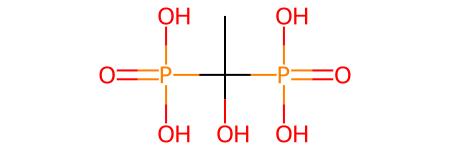

In [6]:
# visualize one 2D molecule.
from rdkit import Chem
Chem.MolFromSmiles(g.smiles)

# Build model

In [7]:
# Atom encoder

class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


# A simple graph neural network model

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(hidden_channels=32)
        self.conv1 = GCNConv(hidden_channels,hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)
        
        
    def forward(self, batch):
        x0 , edge_index, batch_size = batch.x, batch.edge_index, batch.batch
        x = self.emb(x0)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # 

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [8]:
from torch_geometric.nn import Set2Set
from torch_geometric.nn import ResGatedGraphConv
from torch_geometric.nn import GATConv, TransformerConv
class Transformer(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(Transformer, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(hidden_channels=32)
        self.conv1 = GATConv(hidden_channels,hidden_channels, edge_dim = 3)
        self.conv2 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels, edge_dim = 3)
        self.conv4 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)
        self.bn1 = BatchNorm(hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.pooling = Set2Set(hidden_channels, processing_steps = 4)
        
    def forward(self, batch):
        x0 , edge_index, batch_size, edge_attr = batch.x, batch.edge_index, batch.batch, batch.edge_attr
        edge_attr = edge_attr.type(torch.LongTensor)
        x = self.emb(x0)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = self.conv4(x, edge_index)
        #

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [9]:
class res(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(res, self).__init__()
        self.emb = AtomEncoder(hidden_channels = 32)
        self.conv1 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.conv2 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.conv3 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)
    
    def forward(self, batch):
        x0 , edge_index, batch_size, edge_attr = batch.x, batch.edge_index, batch.batch, batch.edge_attr
        x = self.emb(x0)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        # 

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [10]:
# create a model
model = GCN(32, 9, 12)

# prediction
out = model(batch)
print(out.shape) #(num_of_graph, num_of_task)


torch.Size([1024, 12])


In [11]:
import torch
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn.conv import TransformerConv
from torch_geometric.nn import Set2Set
from torch_geometric.nn import BatchNorm

In [12]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = "cpu"

# Supported edge types
SUPPORTED_EDGES = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]

# Supported atoms 
SUPPORTED_ATOMS = ["C", "N", "O", "F", "P", "S", "Cl", "Br", "I"]
ATOMIC_NUMBERS =  [6, 7, 8, 9, 15, 16, 17, 35, 53]

# Dataset (if you change this, delete the processed files to run again)
MAX_MOLECULE_SIZE = 20  

# To remove valence errors ect.
DISABLE_RDKIT_WARNINGS = True

In [13]:
model1 = Transformer(32, 9, 12)

# Start training

In [14]:
# loss function and optimizer
import torch.nn as nn
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.BCEWithLogitsLoss(reduction = "none")

In [15]:
# train and eval function
from sklearn.metrics import roc_auc_score
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(pred.shape).to(torch.float64)

        optimizer.zero_grad()
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        loss = criterion(pred.to(torch.float32)[is_labeled], batch.y.to(torch.float32)[is_labeled]).mean()
        loss.backward()
        optimizer.step()



def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    # For every batch in test loader
    for batch in loader:

        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape))
            y_pred.append(pred)

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    # Compute the ROC - AUC score and store as history
    rocauc_list = []

    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:,i] == y_true[:,i]
            rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))

    if len(rocauc_list) == 0:
        raise RuntimeError('No positively labeled data available. Cannot compute ROC-AUC.')

    return {'rocauc': sum(rocauc_list)/len(rocauc_list)}


In [16]:
model1 = Transformer(32, 9, 12)

In [17]:
model2 = res(32, 9, 12)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
optimizer = optim.Adam(model2.parameters(), lr=0.001)
print("Start training...")
for epoch in range(1, 11):
    print("====epoch " + str(epoch))

    # training
    train(model2, device, train_loader, optimizer = optimizer)

    # evaluating
    train_acc = eval(model2, device, train_loader)
    val_acc = eval(model2, device, val_loader)
    print({'Train': train_acc, 'Validation': val_acc})

Start training...
====epoch 1
{'Train': {'rocauc': 0.7378882820701488}, 'Validation': {'rocauc': 0.7166778056710305}}
====epoch 2
{'Train': {'rocauc': 0.7920720728046722}, 'Validation': {'rocauc': 0.7521601977504302}}
====epoch 3
{'Train': {'rocauc': 0.8141656476025493}, 'Validation': {'rocauc': 0.7596852107874685}}
====epoch 4
{'Train': {'rocauc': 0.826035960616129}, 'Validation': {'rocauc': 0.7654443770844525}}
====epoch 5
{'Train': {'rocauc': 0.8374085554456178}, 'Validation': {'rocauc': 0.7713463399480558}}
====epoch 6
{'Train': {'rocauc': 0.8445408642031156}, 'Validation': {'rocauc': 0.7729141651450497}}
====epoch 7
{'Train': {'rocauc': 0.853395542184329}, 'Validation': {'rocauc': 0.7735870203166701}}
====epoch 8
{'Train': {'rocauc': 0.8575854141957736}, 'Validation': {'rocauc': 0.7733086866048957}}
====epoch 9
{'Train': {'rocauc': 0.8621076124704108}, 'Validation': {'rocauc': 0.7740308977630036}}
====epoch 10
{'Train': {'rocauc': 0.8650173236760529}, 'Validation': {'rocauc': 0.77

In [20]:
class singleres(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(singleres, self).__init__()
        self.emb = AtomEncoder(hidden_channels = 32)
        self.conv1 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.conv2 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.conv3 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)
    
    def forward(self, batch):
        x0 , edge_index, batch_size, edge_attr = batch.x, batch.edge_index, batch.batch, batch.edge_attr
        x = self.emb(x0)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
      # 

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [21]:
model3 = singleres(32, 9, 12)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
print("Start training...")
for epoch in range(1, 11):
    print("====epoch " + str(epoch))

    # training
    train(model3, device, train_loader, optimizer = optimizer)

    # evaluating
    train_acc = eval(model3, device, train_loader)
    val_acc = eval(model3, device, val_loader)
    print({'Train': train_acc, 'Validation': val_acc})

Start training...
====epoch 1
{'Train': {'rocauc': 0.7044288462366683}, 'Validation': {'rocauc': 0.682887238019943}}
====epoch 2
{'Train': {'rocauc': 0.737167686220705}, 'Validation': {'rocauc': 0.7218072783800533}}
====epoch 3
{'Train': {'rocauc': 0.7613893483729725}, 'Validation': {'rocauc': 0.7416578280318445}}
====epoch 4
{'Train': {'rocauc': 0.7795924253976145}, 'Validation': {'rocauc': 0.7497512415451606}}
====epoch 5
{'Train': {'rocauc': 0.794264907838568}, 'Validation': {'rocauc': 0.7551126282051155}}
====epoch 6
{'Train': {'rocauc': 0.806003048982553}, 'Validation': {'rocauc': 0.7597011140504663}}
====epoch 7
{'Train': {'rocauc': 0.8164400217497733}, 'Validation': {'rocauc': 0.7613622944331108}}
====epoch 8
{'Train': {'rocauc': 0.8231512884714604}, 'Validation': {'rocauc': 0.7639033829477732}}
====epoch 9
{'Train': {'rocauc': 0.8281429829180075}, 'Validation': {'rocauc': 0.7652076776671414}}
====epoch 10
{'Train': {'rocauc': 0.8324693078571275}, 'Validation': {'rocauc': 0.7649

In [ ]:
# Training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
optimizer = optim.Adam(model1.parameters(), lr=0.001)
print("Start training...")
for epoch in range(1, 28):
    print("====epoch " + str(epoch))

    # training
    train(model1, device, train_loader, optimizer = optimizer)

    # evaluating
    train_acc = eval(model1, device, train_loader)
    val_acc = eval(model1, device, val_loader)
    print({'Train': train_acc, 'Validation': val_acc})



Start training...
====epoch 1
{'Train': {'rocauc': 0.7900561075866954}, 'Validation': {'rocauc': 0.7497023146404421}}
====epoch 2
{'Train': {'rocauc': 0.845288720372695}, 'Validation': {'rocauc': 0.7587628695691794}}
====epoch 3
{'Train': {'rocauc': 0.8610520293746199}, 'Validation': {'rocauc': 0.7541338192069614}}
====epoch 4
{'Train': {'rocauc': 0.8723723728796894}, 'Validation': {'rocauc': 0.7534637054472589}}
====epoch 5
{'Train': {'rocauc': 0.8724715602140664}, 'Validation': {'rocauc': 0.7451533511710684}}
====epoch 6
{'Train': {'rocauc': 0.8867936803823948}, 'Validation': {'rocauc': 0.7527612276346597}}
====epoch 7
{'Train': {'rocauc': 0.8909183509581938}, 'Validation': {'rocauc': 0.7522644893570645}}
====epoch 8
{'Train': {'rocauc': 0.8940410042586574}, 'Validation': {'rocauc': 0.7510325929475354}}
====epoch 9
{'Train': {'rocauc': 0.8967917621967386}, 'Validation': {'rocauc': 0.7511412659536519}}
====epoch 10
{'Train': {'rocauc': 0.9017894603429729}, 'Validation': {'rocauc': 0.7

In [24]:
batch0 = next(iter(test_loader))
out= model2(batch0)

In [25]:
out

tensor([[-2.2182, -3.6797, -3.9013, -3.2075, -1.8235, -3.9866, -5.2993, -2.5020,
         -5.2670, -4.4865, -3.1108, -3.4061],
        [-2.7026, -3.3673, -2.7314, -3.1737, -1.5764, -2.6934, -3.4927, -1.7101,
         -3.4484, -2.9163, -2.5153, -3.2494],
        [-5.0103, -6.4391, -4.6231, -4.6804, -2.3218, -4.6273, -6.1128, -2.8319,
         -6.4189, -4.7851, -3.7752, -5.3448],
        [-2.0905, -2.3276, -1.2543, -1.9478, -1.5168, -2.1424, -2.2299, -0.7386,
         -2.1566, -1.9183, -1.2547, -1.6281],
        [-3.0705, -3.6202, -2.5693, -2.5874, -1.1168, -1.9073, -3.4724, -1.4559,
         -3.7561, -2.7106, -0.8673, -3.1930],
        [-3.5801, -4.4674, -2.3584, -3.4113, -2.1112, -3.9188, -4.2333, -1.8810,
         -3.9138, -3.4818, -3.0669, -3.4182],
        [-1.0127, -0.6390,  2.6492,  0.9510,  0.4442,  0.9834, -0.0660,  1.2258,
          0.7543,  0.4470,  3.4643,  0.8639],
        [-2.5356, -3.2336,  0.0631, -1.5058, -1.2824, -2.3074, -2.6060, -0.6976,
         -2.0378, -1.7859,  0.

In [26]:
import pandas as pd

In [28]:
out1 = out.detach().numpy()

In [29]:
out1

array([[-2.218249  , -3.679664  , -3.9013472 , -3.207549  , -1.8234892 ,
        -3.986563  , -5.29929   , -2.5019872 , -5.2669864 , -4.4864764 ,
        -3.1108024 , -3.4060636 ],
       [-2.7025828 , -3.3673499 , -2.7313542 , -3.173658  , -1.5764413 ,
        -2.6933959 , -3.4926717 , -1.710114  , -3.4483726 , -2.9162884 ,
        -2.515339  , -3.2493844 ],
       [-5.0102777 , -6.43909   , -4.623052  , -4.6803565 , -2.3218474 ,
        -4.6272984 , -6.1128497 , -2.831858  , -6.4189057 , -4.7851086 ,
        -3.775233  , -5.3448014 ],
       [-2.0904596 , -2.3275793 , -1.2543137 , -1.9477594 , -1.5167558 ,
        -2.142404  , -2.2299414 , -0.7385742 , -2.1566198 , -1.9183242 ,
        -1.2546685 , -1.6281484 ],
       [-3.0705056 , -3.6201978 , -2.569274  , -2.5873613 , -1.1167762 ,
        -1.9073344 , -3.4723535 , -1.4559431 , -3.7560608 , -2.7105744 ,
        -0.8672996 , -3.1930127 ],
       [-3.5801103 , -4.4673886 , -2.3583837 , -3.4113202 , -2.111231  ,
        -3.9188316 , -

In [32]:
df = pd.DataFrame(out1)
df.to_csv('out.csv', index = False, header = False)